In [1]:
#Import some modules
import numpy as np
import pandas as pd
from scipy import interp
%matplotlib inline
import matplotlib.pyplot as plt
import model_fitting as mfit
import loan_roi as lr

from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [2]:
#Read in the training, test, and validation data sets
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')
ROI = pd.read_pickle('ROI')

In [3]:
#Get reliable features without loan amount and interest rate
reliable_feat_no_amnt_intr = mfit.get_reliable_features(X_train.drop(['int_rate', 'loan_amnt'], axis = 1), 
                                                        y_train)

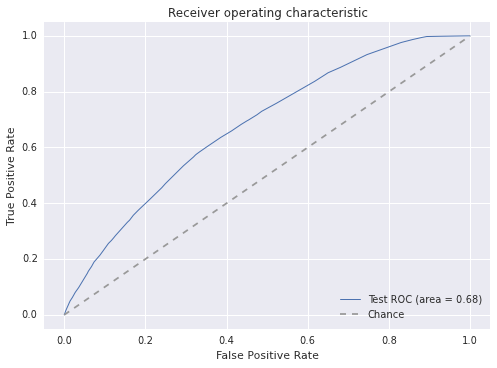

In [4]:
#Fit Decision Tree to training set, plot ROC for test set
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat_no_amnt_intr.index[0:9]], y_train,
                         X_test[reliable_feat_no_amnt_intr.index[0:9]], y_test, DT_clf)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


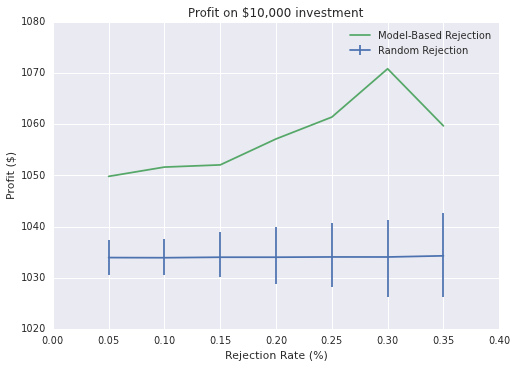

In [5]:
#Look at performance in monetary terms for test set, excluding interest and loan amount
probas_ = DT_clf.predict_proba(X_test[reliable_feat_no_amnt_intr.index[0:9]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_amnt_intr.index[0:9]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_amnt_intr.index[0:9]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [6]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1049.798658,1033.924404,1037.400000,1030.599347,1257.844771
0.10,1051.615782,1033.895066,1037.604167,1030.577778,1257.844771
0.15,1052.043518,1033.993973,1038.926826,1030.182941,1257.844771
0.20,1057.120000,1033.995235,1039.957708,1028.766667,1257.844771
0.25,1061.390000,1034.045361,1040.631971,1028.174063,1257.844771
0.30,1070.833228,1034.037613,1041.216930,1026.155752,1257.844771
0.35,1059.671875,1034.266849,1042.554286,1026.261142,1257.844771


In [7]:
#Create dot file for decision tree
from sklearn.tree import export_graphviz
export_graphviz(DT_clf, out_file = "decision_tree_no_amnt_intr.dot", 
                     feature_names = X_train[reliable_feat_no_amnt_intr.index[0:9]].columns, 
                    class_names = ['paid','default'])

Feature ranking:
1. feature last_cred_pl (0.440599)
2. feature dti (0.159787)
3. feature annual_inc (0.116574)
4. feature revol_util (0.114980)
5. feature total_credit_rv (0.092137)
6. feature inq_last_6mths (0.036385)
7. feature for_business (0.018713)
8. feature has_mortgage (0.011588)
9. feature has_rent (0.009237)


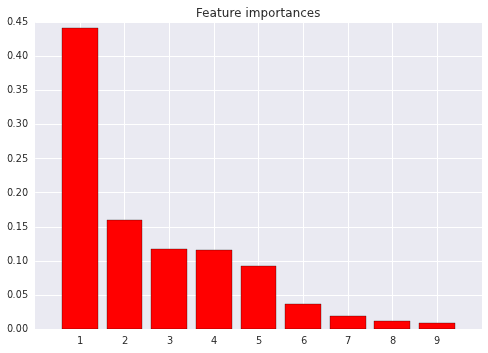

In [8]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat_no_amnt_intr.index[0:9]])

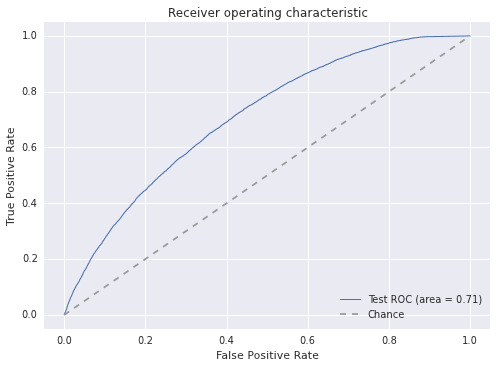

In [9]:
#Fit ensemble of boosted Decision Trees using AdaBoost
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat_no_amnt_intr.index[0:19]], y_train,
                         X_test[reliable_feat_no_amnt_intr.index[0:19]], y_test, AB_clf)

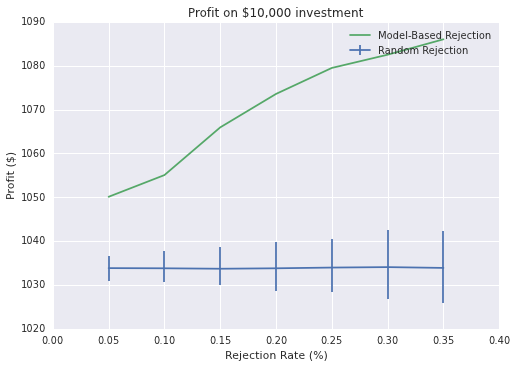

In [10]:
#Look at performance in monetary terms for test set, excluding interest and loan amount
probas_ = AB_clf.predict_proba(X_test[reliable_feat_no_amnt_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_amnt_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_amnt_intr.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [11]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1050.109614,1033.841151,1036.667290,1030.935277,1257.844771
0.10,1055.063189,1033.799685,1037.702222,1030.573214,1257.844771
0.15,1065.942857,1033.699874,1038.741667,1029.941366,1257.844771
0.20,1073.571429,1033.800237,1039.687646,1028.673788,1257.844771
0.25,1079.500000,1033.968800,1040.575576,1028.504768,1257.844771
0.30,1082.517865,1034.070309,1042.575833,1026.704478,1257.844771
0.35,1086.029940,1033.887235,1042.259633,1025.908354,1257.844771


Feature ranking:
1. feature last_cred_pl (0.214827)
2. feature revol_util (0.121662)
3. feature total_credit_rv (0.107898)
4. feature dti (0.092804)
5. feature annual_inc (0.082486)
6. feature erlst_cred (0.064166)
7. feature avg_mort_intr (0.049490)
8. feature prop_edu (0.039543)
9. feature inq_last_6mths (0.036897)
10. feature prop_mort_intr (0.027244)
11. feature prop_itemized (0.026958)
12. feature total_acc (0.026627)
13. feature avg_itemized (0.026575)
14. feature avg_inc (0.021617)
15. feature has_rent (0.019619)
16. feature for_business (0.019196)
17. feature has_mortgage (0.014831)
18. feature for_cc (0.005340)
19. feature avg_SS (0.002219)


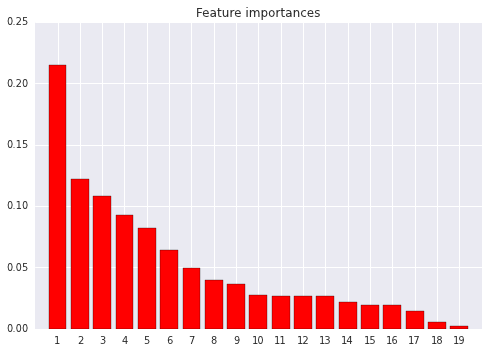

In [12]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat_no_amnt_intr.index[0:19]])

In [15]:
#Fit a stacked learner
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True, random_state=42)
DT_entropy_clf = DecisionTreeClassifier(max_depth = 3, class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                                        criterion = 'entropy')
DT_gini_clf = DecisionTreeClassifier(max_depth = 3, class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                                        criterion = 'gini')

clfs = [RandomForestClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'gini'),
        RandomForestClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'entropy'),
       ExtraTreesClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'gini'),
        ExtraTreesClassifier(n_estimators=100, 
                               min_samples_leaf = 5, 
                               class_weight = {0: (1.0 - 0.1841), 1: 0.1841},
                               n_jobs = -1,
                               criterion = 'entropy'),
       GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50),
       AdaBoostClassifier(base_estimator=DT_entropy_clf, n_estimators=100, random_state=42),
       AdaBoostClassifier(base_estimator=DT_gini_clf, n_estimators=100, random_state=42)]
clf_2 = LogisticRegression(penalty='l2', C=1, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
clfs, clf_2 = mfit.fit_stacked_clf(clfs, clf_2, cv, X_train[reliable_feat_no_amnt_intr[0:43].index], y_train)

Training classifiers with cross-validation
0 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 ExtraTreesClassifier(bootstrap=False, class_weight={0: 0.8159, 1: 0.1841},
           criterion='gini', max_depth=None, max_

Estimating probabilities for test set
Classifier 0
Classifier 1
Classifier 2
Classifier 3
Classifier 4
Classifier 5
Classifier 6


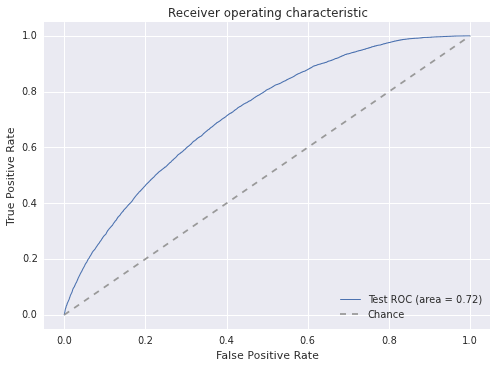

In [16]:
#Predict class probabilities with the stacked learner and plot ROC curve
probas_ = mfit.stacked_clf_predict(clfs, clf_2, X_test[reliable_feat_no_amnt_intr[0:43].index], y_test)

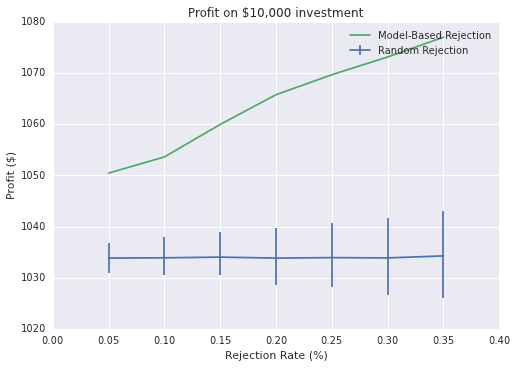

In [17]:
#Plot ROI for the stacked learner
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_amnt_intr[0:43].index].index)
prob_default
pred_ROI = ROI.loc[X_test[reliable_feat_no_amnt_intr.index[0:43]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)

val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [18]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1050.443485,1033.825291,1036.716532,1030.971429,1257.844771
0.10,1053.601429,1033.876098,1037.855268,1030.575699,1257.844771
0.15,1059.958333,1034.016420,1038.927406,1030.465525,1257.844771
0.20,1065.767857,1033.820402,1039.693361,1028.582292,1257.844771
0.25,1069.670000,1033.916034,1040.598611,1028.173625,1257.844771
0.30,1073.143761,1033.857159,1041.578120,1026.702345,1257.844771
0.35,1077.002564,1034.254182,1043.061663,1026.053473,1257.844771


In [19]:
#Test performance when adding loan amount back in
reliable_feat_no_intr = mfit.get_reliable_features(X_train.drop(['int_rate'], axis = 1), 
                                                        y_train)

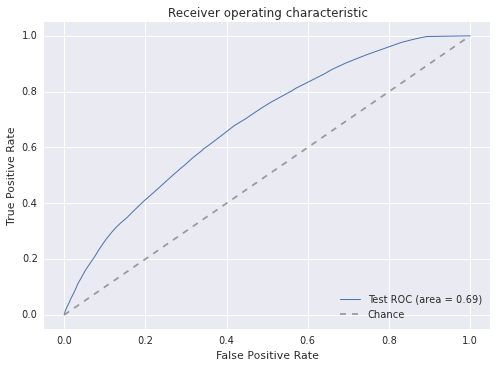

In [20]:
#Fit Decision Tree to training set, plot ROC for test set, include loan amount
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat_no_intr.index[0:24]], y_train,
                         X_test[reliable_feat_no_intr.index[0:24]], y_test, DT_clf)

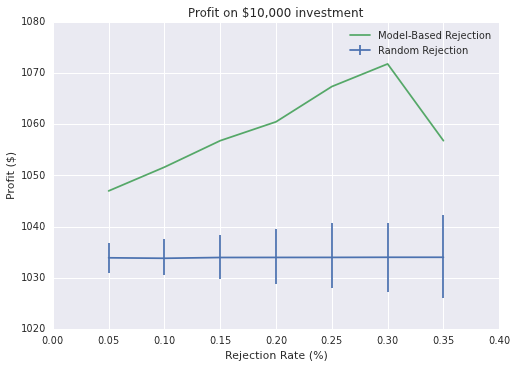

In [21]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = DT_clf.predict_proba(X_test[reliable_feat_no_intr.index[0:24]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_intr.index[0:24]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_intr.index[0:24]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [22]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1046.956250,1033.881428,1036.720083,1030.885321,1257.844771
0.10,1051.604167,1033.786345,1037.577640,1030.576273,1257.844771
0.15,1056.779167,1033.941622,1038.284778,1029.673395,1257.844771
0.20,1060.468983,1033.951236,1039.588982,1028.736958,1257.844771
0.25,1067.361915,1033.958403,1040.629987,1027.950246,1257.844771
0.30,1071.785714,1033.983762,1040.640474,1027.111170,1257.844771
0.35,1056.779167,1033.983446,1042.245390,1025.935373,1257.844771


In [23]:
#Create dot file for decision tree
from sklearn.tree import export_graphviz
export_graphviz(DT_clf, out_file = "decision_tree_wAmnt.dot", 
                     feature_names = X_train[reliable_feat_no_intr.index[0:24]].columns, 
                    class_names = ['paid','default'])

Feature ranking:
1. feature last_cred_pl (0.390532)
2. feature loan_amnt (0.151018)
3. feature dti (0.127671)
4. feature annual_inc (0.122903)
5. feature total_credit_rv (0.078268)
6. feature revol_util (0.069135)
7. feature inq_last_6mths (0.016056)
8. feature erlst_cred (0.009428)
9. feature has_mortgage (0.009279)
10. feature has_rent (0.008316)
11. feature prop_st_loans (0.006702)
12. feature total_acc (0.005513)
13. feature for_business (0.005125)
14. feature avg_inc (0.000053)
15. feature mnths_since_delinq_1st (0.000000)
16. feature for_other (0.000000)
17. feature for_cc (0.000000)
18. feature avg_itemized (0.000000)
19. feature avg_mort_intr (0.000000)
20. feature prop_itemized (0.000000)
21. feature avg_SS (0.000000)
22. feature prop_mort_intr (0.000000)
23. feature for_debt (0.000000)
24. feature prop_edu (0.000000)


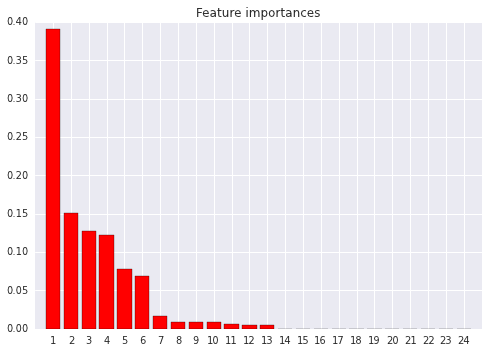

In [24]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat_no_intr.index[0:24]])

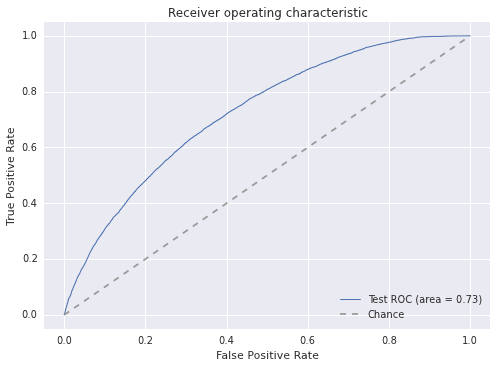

In [25]:
#Fit ensemble of boosted Decision Trees using AdaBoost including loan amount
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat_no_intr.index[0:19]], y_train,
                         X_test[reliable_feat_no_intr.index[0:19]], y_test, AB_clf)

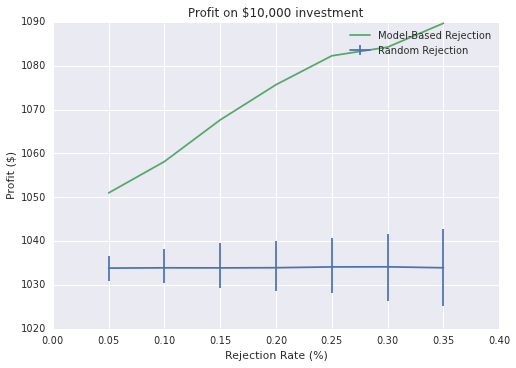

In [26]:
#Look at performance in monetary terms for test set, including loan amount
probas_ = AB_clf.predict_proba(X_test[reliable_feat_no_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_intr.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [27]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1050.992703,1033.842639,1036.690612,1030.901705,1257.844771
0.10,1058.148526,1033.911654,1038.128108,1030.514860,1257.844771
0.15,1067.650000,1033.893238,1039.588235,1029.359558,1257.844771
0.20,1075.680146,1033.932192,1039.955556,1028.626357,1257.844771
0.25,1082.270000,1034.113861,1040.641025,1028.132063,1257.844771
0.30,1084.247917,1034.137113,1041.680476,1026.362036,1257.844771
0.35,1089.688889,1033.918232,1042.659875,1025.229911,1257.844771


Feature ranking:
1. feature last_cred_pl (0.182205)
2. feature annual_inc (0.114227)
3. feature total_credit_rv (0.113764)
4. feature dti (0.092053)
5. feature erlst_cred (0.090546)
6. feature revol_util (0.084875)
7. feature loan_amnt (0.069890)
8. feature total_acc (0.033695)
9. feature prop_edu (0.030976)
10. feature avg_inc (0.030599)
11. feature avg_mort_intr (0.030188)
12. feature prop_itemized (0.030086)
13. feature avg_itemized (0.027595)
14. feature inq_last_6mths (0.022441)
15. feature avg_SS (0.013846)
16. feature for_cc (0.010324)
17. feature has_mortgage (0.009482)
18. feature has_rent (0.008581)
19. feature for_business (0.004629)


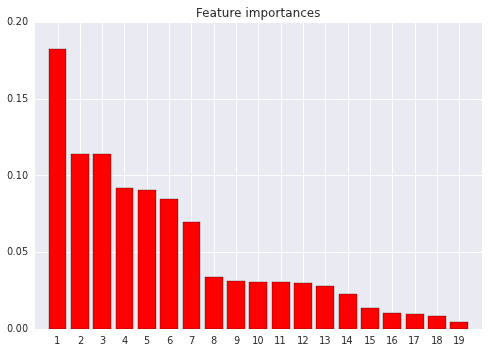

In [28]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat_no_intr.index[0:19]])

In [29]:
#Test stacked learner performance when adding loan amount back in
clfs, clf_2 = mfit.fit_stacked_clf(clfs, clf_2, cv, X_train[reliable_feat_no_intr[0:43].index], y_train)

Training classifiers with cross-validation
0 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
1 RandomForestClassifier(bootstrap=True, class_weight={0: 0.8159, 1: 0.1841},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
2 ExtraTreesClassifier(bootstrap=False, class_weight={0: 0.8159, 1: 0.1841},
           criterion='gini', max_depth=None, max_

Estimating probabilities for test set
Classifier 0
Classifier 1
Classifier 2
Classifier 3
Classifier 4
Classifier 5
Classifier 6


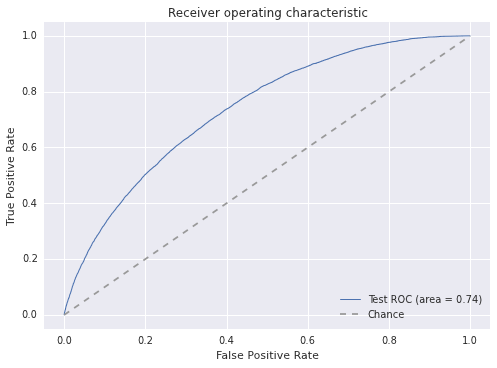

In [30]:
#Predict class probabilities with the stacked learner and plot ROC curve with loan amount
probas_ = mfit.stacked_clf_predict(clfs, clf_2, X_test[reliable_feat_no_intr[0:43].index], y_test)

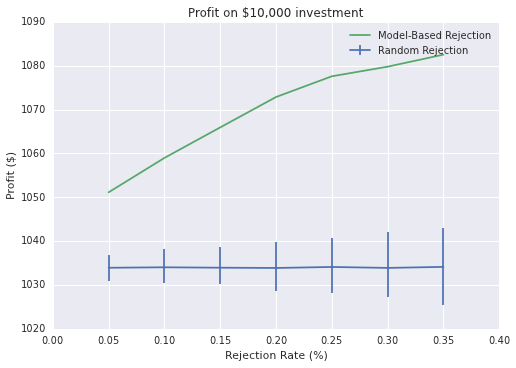

In [31]:
#Plot ROI for the stacked learner with loan amount
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_intr[0:43].index].index)
prob_default
pred_ROI = ROI.loc[X_test[reliable_feat_no_intr.index[0:43]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)

val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [32]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1051.134440,1033.924951,1036.797982,1030.935277,1257.844771
0.10,1058.976763,1034.029048,1038.118750,1030.524168,1257.844771
0.15,1065.937046,1033.938893,1038.547208,1030.193424,1257.844771
0.20,1072.865385,1033.875439,1039.709594,1028.640622,1257.844771
0.25,1077.592817,1034.102544,1040.772002,1028.120000,1257.844771
0.30,1079.788473,1033.890432,1042.081388,1027.186346,1257.844771
0.35,1082.534499,1034.121550,1042.897362,1025.500878,1257.844771


In [33]:
#Test performance when adding interest rate back in
reliable_feat = mfit.get_reliable_features(X_train, y_train)

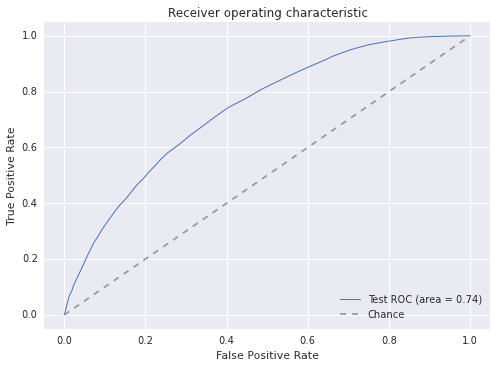

In [34]:
#Fit Decision Tree to training set, plot ROC for test set
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat.index[0:24]], y_train,
                         X_test[reliable_feat.index[0:24]], y_test, DT_clf)

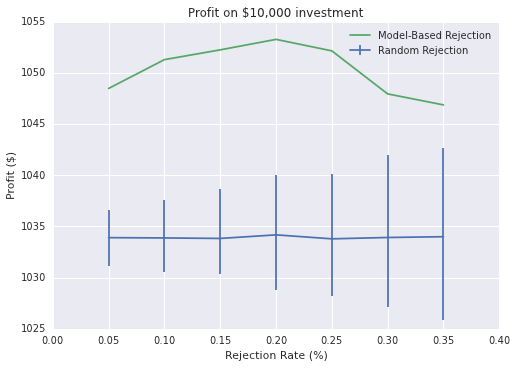

In [37]:
#Look at performance in monetary terms for test set
probas_ = DT_clf.predict_proba(X_test[reliable_feat.index[0:24]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat.index[0:24]].index)
pred_ROI = ROI.loc[X_test[reliable_feat.index[0:24]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [38]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1048.494700,1033.910337,1036.581818,1031.166259,1257.844771
0.10,1051.310872,1033.881738,1037.604083,1030.564979,1257.844771
0.15,1052.266646,1033.833018,1038.641667,1030.351336,1257.844771
0.20,1053.291572,1034.182825,1040.042857,1028.763516,1257.844771
0.25,1052.168608,1033.794562,1040.155564,1028.192388,1257.844771
0.30,1047.962963,1033.925702,1042.031054,1027.111170,1257.844771
0.35,1046.886685,1034.001609,1042.661540,1025.874383,1257.844771


Feature ranking:
1. feature int_rate (0.483180)
2. feature last_cred_pl (0.293562)
3. feature annual_inc (0.112135)
4. feature dti (0.040000)
5. feature loan_amnt (0.036396)
6. feature revol_util (0.012083)
7. feature inq_last_6mths (0.010418)
8. feature has_rent (0.004354)
9. feature prop_itemized (0.003159)
10. feature avg_mort_intr (0.002321)
11. feature total_credit_rv (0.002308)
12. feature total_acc (0.000060)
13. feature prop_st_loans (0.000024)
14. feature has_mortgage (0.000000)
15. feature for_other (0.000000)
16. feature for_business (0.000000)
17. feature prop_edu (0.000000)
18. feature for_cc (0.000000)
19. feature avg_itemized (0.000000)
20. feature erlst_cred (0.000000)
21. feature avg_SS (0.000000)
22. feature prop_mort_intr (0.000000)
23. feature for_debt (0.000000)
24. feature avg_inc (0.000000)


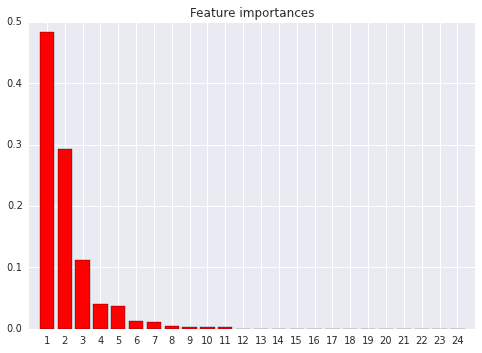

In [39]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat.index[0:24]])

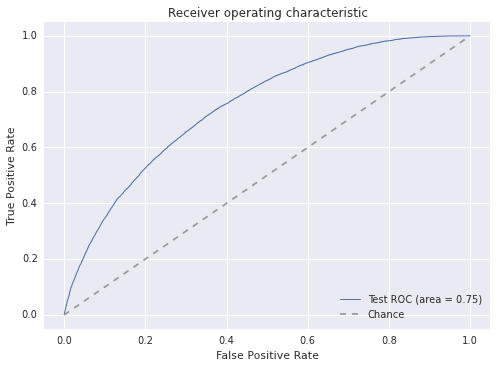

In [42]:
#Fit ensemble of boosted Decision Trees using AdaBoost
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat.index[0:19]], y_train,
                         X_test[reliable_feat.index[0:19]], y_test, AB_clf)

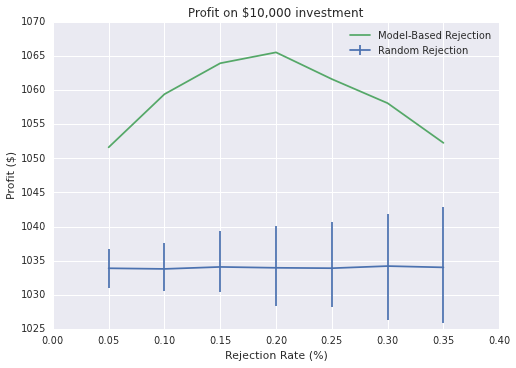

In [43]:
#Look at performance in monetary terms for test set
probas_ = AB_clf.predict_proba(X_test[reliable_feat.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [44]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1051.609974,1033.875390,1036.695921,1030.974490,1257.844771
0.10,1059.397636,1033.780775,1037.588820,1030.523935,1257.844771
0.15,1063.938889,1034.071098,1039.328000,1030.333333,1257.844771
0.20,1065.531983,1033.944277,1040.042857,1028.377778,1257.844771
0.25,1061.613333,1033.886400,1040.630036,1028.137500,1257.844771
0.30,1058.082652,1034.196556,1041.880908,1026.289738,1257.844771
0.35,1052.263096,1034.006205,1042.899683,1025.790667,1257.844771


Feature ranking:
1. feature last_cred_pl (0.191048)
2. feature int_rate (0.122912)
3. feature total_credit_rv (0.100091)
4. feature loan_amnt (0.096574)
5. feature erlst_cred (0.075985)
6. feature annual_inc (0.070399)
7. feature revol_util (0.056083)
8. feature avg_mort_intr (0.049164)
9. feature dti (0.048180)
10. feature prop_itemized (0.042898)
11. feature total_acc (0.035581)
12. feature prop_edu (0.030303)
13. feature inq_last_6mths (0.025839)
14. feature avg_itemized (0.019832)
15. feature avg_inc (0.017180)
16. feature has_mortgage (0.007812)
17. feature for_business (0.005153)
18. feature has_rent (0.002928)
19. feature for_cc (0.002038)


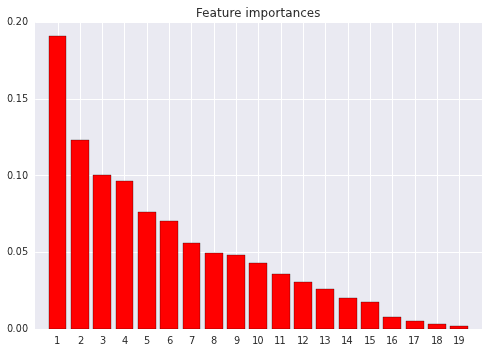

In [45]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat.index[0:19]])

In [ ]:
#Test stacked learner performance when adding loan amount and interest rate back in
clfs, clf_2 = mfit.fit_stacked_clf(clfs, clf_2, cv, X_train[reliable_feat[0:43].index], y_train)

In [ ]:
#Predict class probabilities with the stacked learner and plot ROC curve with loan amount
probas_ = mfit.stacked_clf_predict(clfs, clf_2, X_test[reliable_feat[0:43].index], y_test)

In [ ]:
#Plot ROI for the stacked learner with loan amount and interest
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat[0:43].index].index)
prob_default
pred_ROI = ROI.loc[X_test[reliable_feat.index[0:43]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)

val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)